# LSTM — Prédiction autorégressiive de la dernière semaine

## Objectif
Ce notebook construit un **LSTM (Long Short-Term Memory)** pour prédire `Total_reservations`
via une **fenêtre glissante autorégressiive**.

## Architecture
```
Input (batch, WINDOW, n_features)
   ↓
LSTM(hidden=HIDDEN_SIZE, layers=NUM_LAYERS, dropout=DROPOUT)
   ↓  h_T  (batch, HIDDEN_SIZE)
Dropout
   ↓
Linear(HIDDEN_SIZE → 1)
   ↓
Total_reservations normalisé [0, 1]
```

## Pourquoi le LSTM résout le vanishing gradient ?
Le LSTM introduit une **cellule de contexte** $c_t$ mise à jour par additions :
$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$
Les gradients peuvent traverser le temps sans disparaître, contrairement au SimpleRNN.

## Stratégie autorégressiive
Pour prédire la **dernière semaine** (5 jours) :
1. Fenêtre initiale = les `WINDOW` jours précédents (valeurs réelles)
2. Prédiction du lundi → injectée dans la fenêtre
3. Prédiction du mardi avec la fenêtre glissée → etc.
4. Les **features exogènes** (météo, jours fériés) sont connues à l'avance et utilisées telles quelles.

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `EPOCHS` | 200 | Epochs max d'entraînement |
| `HIDDEN_SIZE` | 64 | Dimension de l'état caché |
| `NUM_LAYERS` | 2 | Couches LSTM empilées |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [31]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH   = '../data/df_venues_final.csv'
TARGET_COL  = 'GLOBAL'   # variable à prédire
MODEL_NAME  = 'LSTM'

WINDOW      = 5      # jours de contexte (fenêtre glissante)
N_TEST      = 5      # jours de test = dernière semaine
N_VAL       = 20     # jours de validation (~4 semaines)

# Entraînement
EPOCHS      = 200
LR          = 1e-3
BATCH_SIZE  = 16
WEIGHT_DECAY = 1e-5
PATIENCE    = 20     # early stopping : patience en epochs

# Architecture LSTM
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2

# Features utilisées (ordre fixe — TARGET_COL en index 0 pour l'autoregression)
FEATURES = [
    'GLOBAL',               # idx 0 — feedback autorégressif
    'Total_reservations', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0   # index de TARGET_COL dans FEATURES

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = f'../img/{MODEL_NAME.lower()}_results.png'

## 2 — Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : cpu


## 3 — Chargement et tri chronologique

Les données sont triées par **(Annee, Semaine, jour de la semaine)** pour respecter l'ordre temporel.
Les colonnes booléennes (`jour_*`) sont converties en entiers.

In [33]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"
print(f'Période : {df["Annee"].min()}/S{df["Semaine"].min()} → {df["Annee"].max()}/S{df["Semaine"].max()}')
print(f'\n--- Dernière semaine de test ({TEST_LABEL}) ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine de test (S39/2023) ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Prétraitement, split et séquences

### Split temporel hold-out
```
|←────────── Train (225 j) ──────────→|←── Val (20 j) ──→|← Test (5 j) →|
   S1/2022 → S12/2023                    S13 → S16/2023     S39/2023
```
- **Train** : apprentissage des poids du modèle
- **Val** : early stopping — les meilleurs poids sont ceux minimisant la val loss
- **Test** : évaluation finale (jamais vu pendant l'entraînement)

> ⚠️ Règle absolue : le scaler est ajusté **uniquement sur le train**
> pour éviter toute fuite d'information (data leakage) du futur vers le passé.

### Normalisation
`MinMaxScaler` ajusté sur le train, appliqué au val et au test.

### Séquences glissantes
Chaque sample `(X, y)` : fenêtre de `WINDOW` jours → cible du jour suivant.

In [34]:
scaler   = MinMaxScaler()

# ── Split temporel strict : Train | Val | Test ───────────────────────────
n_total    = len(df)
test_start = n_total - N_TEST          # premier jour du test   (ex: 245)
val_start  = test_start - N_VAL        # premier jour de la val (ex: 225)

# Scaler ajusté UNIQUEMENT sur le train (pas de data leakage)
scaler.fit(df[FEATURES].astype(float).iloc[:val_start])
X_scaled = scaler.transform(df[FEATURES].astype(float))

X_train_raw = X_scaled[:val_start]                        # 0 → val_start-1
X_val_raw   = X_scaled[val_start - WINDOW : test_start]   # contexte inclu
X_test_raw  = X_scaled[test_start:]                       # derniers N_TEST jours

def make_sequences(X, window):
    """Transforme un tableau (N, F) en séquences glissantes pour apprentissage supervisé."""
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])
        ys.append(X[i, TARGET_IDX])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32).reshape(-1, 1)

X_seq,     y_seq     = make_sequences(X_train_raw, WINDOW)   # séquences train
X_val_seq, y_val_seq = make_sequences(X_val_raw,   WINDOW)   # séquences val

# Labels de période
_val      = df.iloc[val_start  : test_start]
VAL_LABEL = f"S{int(_val.iloc[0]['Semaine'])}–S{int(_val.iloc[-1]['Semaine'])}/{int(_val.iloc[-1]['Annee'])}"

print('=== Split temporel ===')
print(f'  Train : {val_start:3d} jours  (0 – {val_start-1})')
print(f'  Val   : {N_VAL:3d} jours  ({val_start} – {test_start-1})  [{VAL_LABEL}]')
print(f'  Test  : {N_TEST:3d} jours  ({test_start} – {n_total-1})  [{TEST_LABEL}]')
print(f'\nSéquences → Train : {X_seq.shape}  |  Val : {X_val_seq.shape}')
seed_start = test_start - WINDOW
print(f'\nFenêtre seed test (indices {seed_start}–{test_start-1}) :')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].iloc[seed_start:test_start].to_string())

X_tr  = torch.tensor(X_seq).to(DEVICE)
y_tr  = torch.tensor(y_seq).to(DEVICE)
X_val = torch.tensor(X_val_seq).to(DEVICE)
y_val = torch.tensor(y_val_seq).to(DEVICE)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)

=== Split temporel ===
  Train : 225 jours  (0 – 224)
  Val   :  20 jours  (225 – 244)  [S35–S38/2023]
  Test  :   5 jours  (245 – 249)  [S39/2023]

Séquences → Train : (220, 5, 15)  |  Val : (20, 5, 15)

Fenêtre seed test (indices 240–244) :
     Annee  Semaine  day_num  GLOBAL
240   2023       38        0     676
241   2023       38        1     764
242   2023       38        2     714
243   2023       38        3     677
244   2023       38        4     558


## 5 — Architecture LSTM

```
Input  : (batch, WINDOW=5, n_features=15)
   ↓
LSTM(hidden=64, layers=2, dropout=0.2)
   ↓  h_T  (batch, 64)
Dropout(0.2)
   ↓
Linear(64 → 1)
   ↓
Total_reservations normalisé [0, 1]
```

**Différence avec GRU/RNN :** le LSTM maintient deux états : `h_t` (état caché) et `c_t` (cellule
de contexte). La cellule permet aux gradients de circuler sans disparaître (**Long Short-Term Memory**).

**Sorties de `nn.LSTM`** : `(output, (h_n, c_n))` — on utilise uniquement le dernier `h_T`.

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _  = self.lstm(x)               # (batch, T, hidden)
        last_h  = out[:, -1, :]              # dernier pas de temps
        return self.fc(self.dropout(last_h))  # (batch, 1)


model = LSTMModel(input_size=len(FEATURES)).to(DEVICE)
print(model)
print(f'\nNombre de paramètres : {sum(p.numel() for p in model.parameters()):,}')

LSTMModel(
  (lstm): LSTM(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre de paramètres : 54,081


## 6 — Entraînement avec early stopping sur la val loss

- **Optimiseur** : Adam avec weight decay
- **Scheduler** : `ReduceLROnPlateau` sur la **val loss** (divise le LR par 2 si stagnation)
- **Loss** : MSE sur les valeurs normalisées
- **Early stopping** : surveille la val loss — restaure les meilleurs poids à la fin
- **Gradient clipping** : norme max = 1.0

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=PATIENCE, factor=0.5
)

loss_history  = {'train': [], 'val': []}
best_val_loss = float('inf')
best_state    = None
no_improve    = 0

for epoch in range(1, EPOCHS + 1):
    # ── Phase train ───────────────────────────────────────────────────────
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_loss = epoch_loss / len(X_seq)

    # ── Phase validation ──────────────────────────────────────────────────
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val).item()

    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)

    # ── Early stopping sur la val loss ────────────────────────────────────
    scheduler.step(val_loss)
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state    = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve    = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE * 2:
            print(f'Early stopping epoch {epoch}  (best val MSE = {best_val_loss:.5f})')
            break

    if epoch % 50 == 0:
        lr_cur = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}/{EPOCHS} | Train : {train_loss:.5f} | Val : {val_loss:.5f} | LR : {lr_cur:.6f}')

if best_state:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f'\nMeilleurs poids restaurés  (val MSE = {best_val_loss:.5f})')
print('Entraînement terminé.')

Epoch  50/200 | Train : 0.01392 | Val : 0.00318 | LR : 0.001000
Early stopping epoch 78  (best val MSE = 0.00204)

Meilleurs poids restaurés  (val MSE = 0.00204)
Entraînement terminé.


## 7 — Prédiction autorégressiive (fenêtre glissante)

**Pour chaque jour `t` de la semaine cible :**

1. Construire le tenseur `x` depuis la fenêtre courante `(WINDOW × n_features)`
2. Passer `x` dans le LSTM → `ŷ_t` normalisé
3. Créer le vecteur du jour `t` : features exogènes réelles + `Total_reservations = ŷ_t`
4. Glisser la fenêtre : `window = [window[1:], nouveau_jour]`
5. Répéter pour `t+1`

⚠️ Les features exogènes (météo, jours fériés…) sont connues à l'avance → on utilise les vraies valeurs.

In [37]:
model.eval()

seed_window = X_scaled[-N_TEST - WINDOW : -N_TEST].copy()
preds_norm  = []
window      = seed_window.copy()

print('=== Prédiction autorégressiive (fenêtre glissante) ===')
print(f"{'Étape':<6} {'Jour':<10} {'ŷ norm':>8}   Fenêtre {TARGET_COL} [normalisé]")
print('-' * 70)

for step in range(N_TEST):
    x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_n = model(x).item()
    preds_norm.append(pred_n)

    print(f'  {step}     {DAY_LABELS[step]:<10} {pred_n:>8.4f}   '
          f'{np.round(window[:, TARGET_IDX], 3)}')

    new_day             = X_test_raw[step].copy()
    new_day[TARGET_IDX] = pred_n
    window = np.vstack([window[1:], new_day.reshape(1, -1)])

# Dénormalisation
dummy                = np.zeros((N_TEST, len(FEATURES)))
dummy[:, TARGET_IDX] = preds_norm
preds_real = scaler.inverse_transform(dummy)[:, TARGET_IDX]
real_real  = df[TARGET_COL].values[-N_TEST:]

print('\n=== Résultats ===')
print(f"{'Jour':<10} | {'Réel':>6} | {MODEL_NAME:>6} | {'Erreur':>7} | {'Erreur %':>8}")
print('-' * 48)
for i, d in enumerate(DAY_LABELS):
    err    = preds_real[i] - real_real[i]
    err_pc = 100 * abs(err) / real_real[i]
    print(f'{d:<10} | {real_real[i]:>6.0f} | {preds_real[i]:>6.0f} | {err:>+7.0f} | {err_pc:>7.1f}%')

=== Prédiction autorégressiive (fenêtre glissante) ===
Étape  Jour         ŷ norm   Fenêtre GLOBAL [normalisé]
----------------------------------------------------------------------
  0     Lundi        0.7055   [0.718 0.814 0.76  0.719 0.589]
  1     Mardi        0.8192   [0.814 0.76  0.719 0.589 0.705]
  2     Mercredi     0.7979   [0.76  0.719 0.589 0.705 0.819]
  3     Jeudi        0.7201   [0.719 0.589 0.705 0.819 0.798]
  4     Vendredi     0.5197   [0.589 0.705 0.819 0.798 0.72 ]

=== Résultats ===
Jour       |   Réel |   LSTM |  Erreur | Erreur %
------------------------------------------------
Lundi      |    624 |    665 |     +41 |     6.5%
Mardi      |    713 |    769 |     +56 |     7.8%
Mercredi   |    623 |    749 |    +126 |    20.2%
Jeudi      |    659 |    678 |     +19 |     2.9%
Vendredi   |    408 |    495 |     +87 |    21.2%


## 8 — Métriques

Deux types d'évaluation distincts :

| | **Val (1-step direct)** | **Test (autorégressif)** |
|---|---|---|
| Données | Val set (20 jours) | Dernière semaine (5 jours) |
| Méthode | Prédiction 1 pas en avant directe | Prédictions enchaînées (sortie → entrée) |
| Rôle | Évaluer la généralisation sur fenêtre longue | Simuler l'usage réel (semaine inconnue) |

| Métrique | Formule | Interprétation |
|----------|---------|----------------|
| **MAE** | $\frac{1}{n}\sum\|y_i - \hat{y}_i\|$ | Erreur moyenne en venues |
| **MAPE** | $\frac{100}{n}\sum\frac{\|y_i - \hat{y}_i\|}{y_i}$ | Erreur relative % |
| **RMSE** | $\sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$ | Pénalise les grandes erreurs |
| **R²** | $1 - \frac{SS_{res}}{SS_{tot}}$ | 1 = parfait, 0 = modèle naïf |

In [38]:
# ── Métriques Val : prédiction directe 1-pas ─────────────────────────────
model.eval()
with torch.no_grad():
    val_preds_norm = model(X_val).cpu().numpy().flatten()

dummy_val                = np.zeros((N_VAL, len(FEATURES)))
dummy_val[:, TARGET_IDX] = val_preds_norm
val_preds_real = scaler.inverse_transform(dummy_val)[:, TARGET_IDX]
val_real       = df[TARGET_COL].values[val_start : test_start]

mae_val  = mean_absolute_error(val_real, val_preds_real)
mape_val = mean_absolute_percentage_error(val_real, val_preds_real) * 100
rmse_val = np.sqrt(np.mean((val_real - val_preds_real) ** 2))
r2_val   = r2_score(val_real, val_preds_real)

# ── Métriques Test : prédiction autorégressiive ───────────────────────────
mae  = mean_absolute_error(real_real, preds_real)
mape = mean_absolute_percentage_error(real_real, preds_real) * 100
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
r2   = r2_score(real_real, preds_real)

# ── Affichage comparatif ──────────────────────────────────────────────────
W = 54
print(f'{"="*W}')
print(f'  {MODEL_NAME} — Métriques de généralisation')
print(f'{"="*W}')
print(f'  {"Métrique":<18} {"Val 1-step":>14} {"Test autorégressif":>18}')
print(f'  {"-"*W}')
print(f'  {"MAE  (venues)":<18} {mae_val:>14.1f} {mae:>18.1f}')
print(f'  {"MAPE (%)":<18} {mape_val:>14.2f} {mape:>18.2f}')
print(f'  {"RMSE (venues)":<18} {rmse_val:>14.1f} {rmse:>18.1f}')
print(f'  {"R²":<18} {r2_val:>14.4f} {r2:>18.4f}')
print(f'{"="*W}')
print(f'  Val  = {VAL_LABEL} (prédiction directe 1-pas)')
print(f'  Test = {TEST_LABEL} (autorégressif {N_TEST} jours)')

  LSTM — Métriques de généralisation
  Métrique               Val 1-step Test autorégressif
  ------------------------------------------------------
  MAE  (venues)                34.2               65.5
  MAPE (%)                     6.16              11.72
  RMSE (venues)                41.3               75.4
  R²                         0.8768             0.4738
  Val  = S35–S38/2023 (prédiction directe 1-pas)
  Test = S39/2023 (autorégressif 5 jours)


## 9 — Visualisations

Trois graphiques standardisés (identiques pour tous les modèles) :
1. **Courbe d'apprentissage** — convergence de la loss MSE par epoch
2. **Série complète + prédiction** — vue globale avec zoom sur la semaine de test
3. **Barres côte à côte** — comparaison jour par jour réel vs prédit

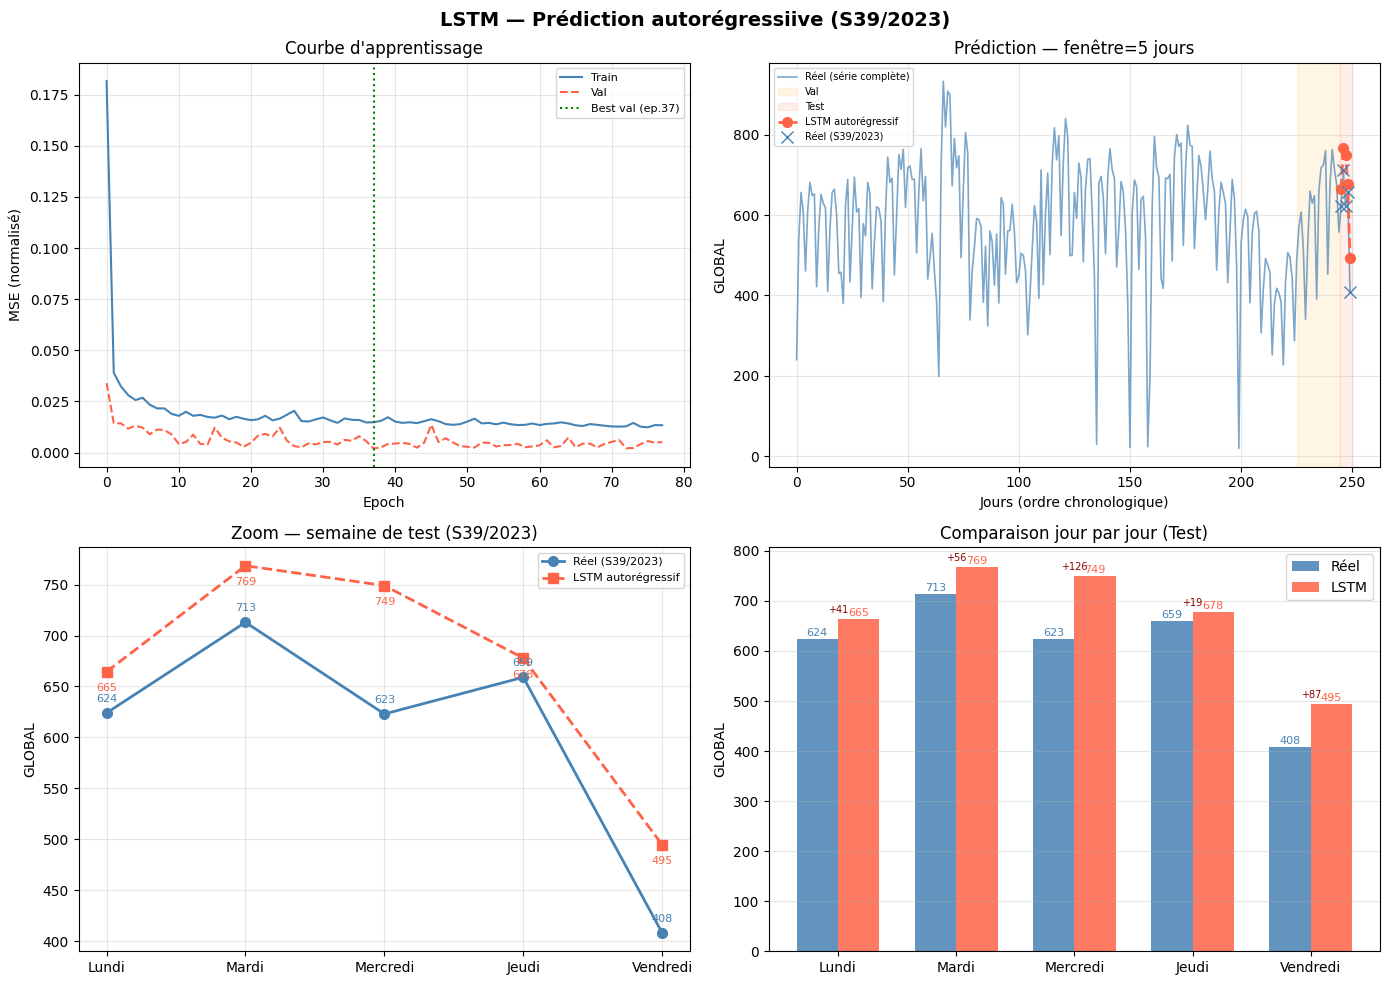

Figure sauvegardée → ../img/lstm_results.png


In [39]:
all_real     = df[TARGET_COL].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))
val_indices  = list(range(val_start, test_start))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'{MODEL_NAME} — Prédiction autorégressiive ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Courbes d'apprentissage (train + val) ─────────────────────────────
ax = axes[0, 0]
ax.plot(loss_history['train'], color='steelblue', lw=1.5, label='Train')
ax.plot(loss_history['val'],   color='tomato',    lw=1.5, ls='--', label='Val')
best_ep = int(np.argmin(loss_history['val']))
ax.axvline(x=best_ep, color='green', ls=':', lw=1.5, label=f'Best val (ep.{best_ep})')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE (normalisé)')
ax.set_title("Courbe d'apprentissage")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 2 : Série complète + périodes val/test ────────────────────────────────
ax = axes[0, 1]
ax.plot(range(len(all_real)), all_real,
        label='Réel (série complète)', color='steelblue', alpha=0.7, lw=1.2)
ax.axvspan(val_start, test_start - 0.5, alpha=0.10, color='orange', label='Val')
ax.axvspan(test_start - 0.5, len(all_real), alpha=0.10, color='tomato', label='Test')
ax.plot(test_indices, preds_real,
        label=f'{MODEL_NAME} autorégressif', color='tomato',
        ls='--', marker='o', ms=7, lw=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', ms=9, ls='None', label=f'Réel ({TEST_LABEL})')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Prédiction — fenêtre={WINDOW} jours')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

# ── 3 : Zoom semaine de test ──────────────────────────────────────────────
ax = axes[1, 0]
ax.plot(DAY_LABELS, real_real,  'o-', color='steelblue', ms=7, lw=2, label=f'Réel ({TEST_LABEL})')
ax.plot(DAY_LABELS, preds_real, 's--', color='tomato',   ms=7, lw=2, label=f'{MODEL_NAME} autorégressif')
for i, (r, p) in enumerate(zip(real_real, preds_real)):
    ax.annotate(f'{r:.0f}', (i, r), textcoords='offset points', xytext=(0, 8),
                ha='center', fontsize=8, color='steelblue')
    ax.annotate(f'{p:.0f}', (i, p), textcoords='offset points', xytext=(0, -14),
                ha='center', fontsize=8, color='tomato')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Zoom — semaine de test ({TEST_LABEL})')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 4 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[1, 1]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel',     color='steelblue', alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label=MODEL_NAME, color='tomato',    alpha=0.85)
for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='tomato')
ax.set_xticks(x)
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Comparaison jour par jour (Test)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i in range(N_TEST):
    err = preds_real[i] - real_real[i]
    ax.text(i, max(real_real[i], preds_real[i]) + 12,
            f'{err:+.0f}', ha='center', fontsize=7, color='darkred')

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 10 — Trace de la fenêtre glissante

Récapitulatif des prédictions injectées à chaque étape.

In [40]:
print(f'=== Trace de la fenêtre glissante — {MODEL_NAME} ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7} {'Err abs':>8} {'Err %':>7}   Rôle")
print('-' * 75)
for i, d in enumerate(DAY_LABELS):
    err_abs = abs(preds_real[i] - real_real[i])
    err_pct = 100 * err_abs / real_real[i]
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f} {err_abs:>8.1f} {err_pct:>6.1f}%   {role}')

print(f'\nRésumé : MAE={mae:.1f} | MAPE={mape:.2f}% | RMSE={rmse:.1f} | R²={r2:.4f}')

=== Trace de la fenêtre glissante — LSTM ===
Étape   Jour           Réel  Prédit  Err abs   Err %   Rôle
---------------------------------------------------------------------------
  0      Lundi           624     665     40.5    6.5%   ← injecté dans la fenêtre suivante
  1      Mardi           713     769     55.5    7.8%   ← injecté dans la fenêtre suivante
  2      Mercredi        623     749    126.0   20.2%   ← injecté dans la fenêtre suivante
  3      Jeudi           659     678     18.9    2.9%   ← injecté dans la fenêtre suivante
  4      Vendredi        408     495     86.5   21.2%   ← prédiction finale

Résumé : MAE=65.5 | MAPE=11.72% | RMSE=75.4 | R²=0.4738


In [41]:
import json, os

os.makedirs('../results', exist_ok=True)

results_data = {
    'model'      : MODEL_NAME,
    'color'      : 'tomato',
    'val'        : {'MAE': mae_val, 'MAPE': mape_val, 'RMSE': rmse_val, 'R2': r2_val},
    'test'       : {'MAE': mae,     'MAPE': mape,     'RMSE': rmse,     'R2': r2},
    'preds'      : [float(x) for x in preds_real],
    'real'       : [float(x) for x in real_real],
    'day_labels' : DAY_LABELS,
    'test_label' : TEST_LABEL,
}

out_path = f'../results/{MODEL_NAME.lower()}_results.json'
with open(out_path, 'w') as f:
    json.dump(results_data, f, indent=2)
print(f'Résultats sauvegardés → {out_path}')

Résultats sauvegardés → ../results/lstm_results.json
